In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [85]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\User\Documents\wetter\notebooks


In [86]:
stations_meta = pd.read_csv(
    '../data/terminwerte_TU_00183_akt/Metadaten_Geographie_00183.txt',
    sep=';',
    encoding='utf-8',       # ggf. 'latin1' je nach Quelle
    skipfooter=1,
    engine='python'
)

# 'eor' ist nur ein Platzhalter → entfernen
if 'eor' in stations_meta.columns:
    stations_meta = stations_meta.drop(columns=['eor'])

stations_meta

,Stations_id,Stationshoehe,Geogr.Breite,Geogr.Laenge,von_datum,bis_datum,Stationsname
0,183,42.0,54.6804,13.4327,18780601,19460831,Arkona
1,183,42.0,54.6791,13.4345,19460901,20060810,Arkona
2,183,42.0,54.6791,13.4344,20060811,20110903,Arkona


In [87]:
# Messdaten einlesen
station_data = pd.read_csv(
    '../data/terminwerte_TU_00183_akt/produkt_tu_termin_20240413_20251014_00183.txt',
    sep=';',
    encoding='utf-8',
    skipfooter=1,       # ignoriert z. B. "generiert: ..." am Ende
    engine='python'
)

# 'eor'-Spalte entfernen, falls vorhanden
if 'eor' in station_data.columns:
    station_data = station_data.drop(columns=['eor'])

# Datum und Uhrzeit parsen (Format: YYYYMMDDHH)
station_data['MESS_DATUM'] = pd.to_datetime(station_data['MESS_DATUM'], format='%Y%m%d%H')
station_data.head()

,STATIONS_ID,MESS_DATUM,QN_4,TT_TER,RF_TER
0,183,2024-04-13 06:00:00,9,9.9,90.0
1,183,2024-04-13 12:00:00,9,14.0,82.0
2,183,2024-04-13 18:00:00,9,12.1,85.0
3,183,2024-04-14 06:00:00,9,9.0,78.0
4,183,2024-04-14 12:00:00,9,10.6,69.0


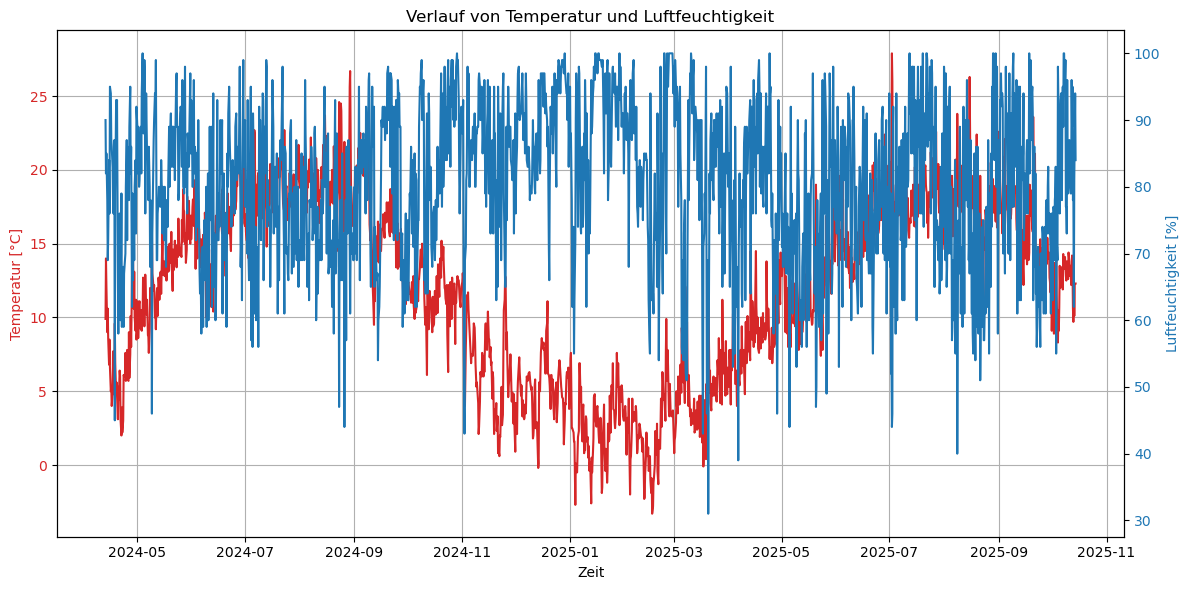

In [88]:

# Setze den Zeitstempel als Index, falls noch nicht geschehen
station_data = station_data.set_index('MESS_DATUM')

# Plot-Grundgerüst
fig, ax1 = plt.subplots(figsize=(12, 6))

# Linke y-Achse: Temperatur
color_temp = 'tab:red'
ax1.set_xlabel('Zeit')
ax1.set_ylabel('Temperatur [°C]', color=color_temp)
ax1.plot(station_data.index, station_data['TT_TER'], color=color_temp, label='Temperatur')
ax1.tick_params(axis='y', labelcolor=color_temp)

# Rechte y-Achse: Luftfeuchtigkeit
ax2 = ax1.twinx()
color_humidity = 'tab:blue'
ax2.set_ylabel('Luftfeuchtigkeit [%]', color=color_humidity)
ax2.plot(station_data.index, station_data['RF_TER'], color=color_humidity, label='Luftfeuchtigkeit')
ax2.tick_params(axis='y', labelcolor=color_humidity)

# Titel, Grid und Layout
plt.title('Verlauf von Temperatur und Luftfeuchtigkeit')
ax1.grid(True)
fig.tight_layout()
plt.show()

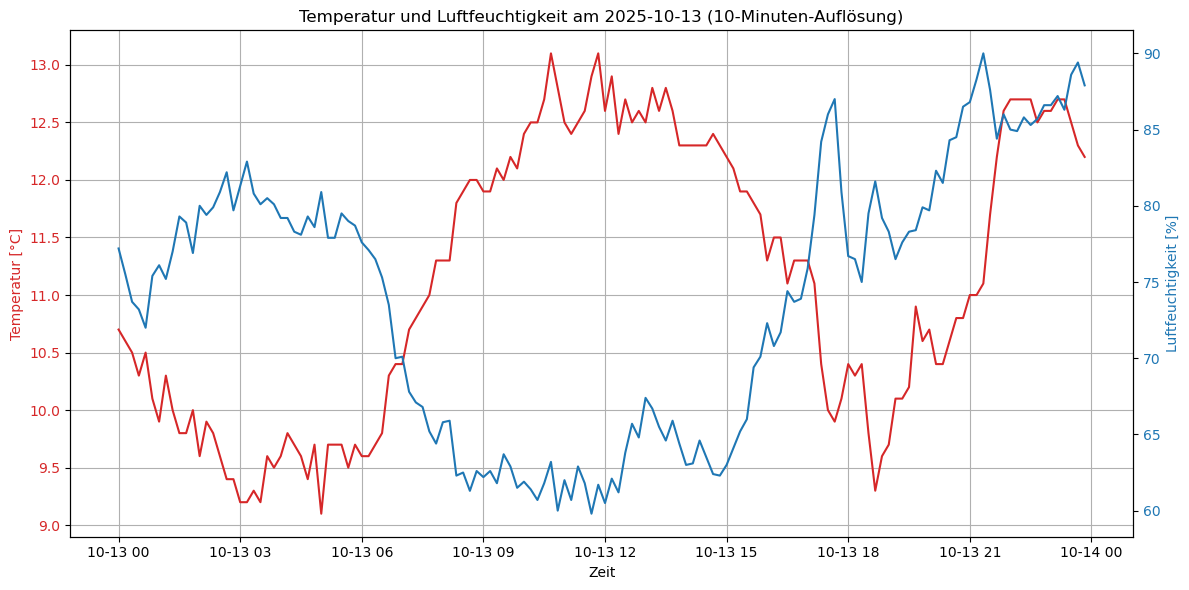

In [89]:
# 1. Daten laden
station_data_air_10min = pd.read_csv(
    '../data/10minutenwerte_00183_akt/produkt_zehn_min_tu_20240413_20251014_00183.txt',  # Pfad anpassen
    sep=';',
    encoding='utf-8',
    skipfooter=1,
    engine='python'
)

# 2. 'eor' Spalte entfernen
if 'eor' in station_data_air_10min.columns:
    station_data_air_10min = station_data_air_10min.drop(columns=['eor'])

# 3. MESS_DATUM in datetime umwandeln (Format: YYYYMMDDHHMM, also 12 Stellen)
if station_data_air_10min['MESS_DATUM'].astype(str).str.len().max() == 12:
    station_data_air_10min['MESS_DATUM'] = pd.to_datetime(
        station_data_air_10min['MESS_DATUM'], format='%Y%m%d%H%M'
    )
else:
    raise ValueError('Unbekanntes Datumsformat in MESS_DATUM')

# 4. Index setzen und sortieren
station_data_air_10min = station_data_air_10min.set_index('MESS_DATUM').sort_index()

# 5. (Optional) Resample nicht nötig, wenn Daten schon 10-minütig vorliegen.
# Falls trotzdem fehlende Zeitpunkte interpoliert werden sollen, kannst du es so machen:
# station_data_air_10min = station_data_air_10min.resample('10T').interpolate(method='linear')

# 6. Einzelnen Tag auswählen, z.B. 13.04.2024
tag = '2025-10-13'
station_day = station_data_air_10min.loc[tag]

# 7. Plot mit Temperatur (TT_10) und Luftfeuchtigkeit (RF_10)
fig, ax1 = plt.subplots(figsize=(12,6))

color_temp = 'tab:red'
ax1.set_xlabel('Zeit')
ax1.set_ylabel('Temperatur [°C]', color=color_temp)
ax1.plot(station_day.index, station_day['TT_10'], color=color_temp, label='Temperatur (TT_10)')
ax1.tick_params(axis='y', labelcolor=color_temp)

ax2 = ax1.twinx()
color_humidity = 'tab:blue'
ax2.set_ylabel('Luftfeuchtigkeit [%]', color=color_humidity)
ax2.plot(station_day.index, station_day['RF_10'], color=color_humidity, label='Luftfeuchtigkeit (RF_10)')
ax2.tick_params(axis='y', labelcolor=color_humidity)

plt.title(f'Temperatur und Luftfeuchtigkeit am {tag} (10-Minuten-Auflösung)')
ax1.grid(True)
fig.tight_layout()
plt.show()

In [90]:
station_day = station_data_air_10min.loc[tag]

# Differenzen berechnen
temp_diff = station_day['TT_10'].diff().abs()
rf_diff = station_day['RF_10'].diff().abs()

# Schwellenwerte definieren (kannst du anpassen)
temp_threshold = 2.0   # 2 Grad Celsius Sprung
rf_threshold = 10.0    # 10 % Luftfeuchte Sprung

# Sprünge finden
temp_jumps = temp_diff[temp_diff > temp_threshold]
rf_jumps = rf_diff[rf_diff > rf_threshold]

# Ergebnisse anzeigen
print("Große Temperatursprünge (°C):")
temp_jumps

print("\nGroße Luftfeuchtigkeitssprünge (%):")
rf_jumps


Große Temperatursprünge (°C):

Große Luftfeuchtigkeitssprünge (%):


Series([], Name: RF_10, dtype: float64)

In [91]:
# Beispiel für Oktober 2025
monat = '2025-08'
station_month = station_data_air_10min.loc[monat]

In [92]:
temp_diff_30min = station_month['TT_10'] - station_month['TT_10'].shift(3)
temp_diff_30min = temp_diff_30min.abs()

rf_diff_30min = station_month['RF_10'] - station_month['RF_10'].shift(3)
rf_diff_30min = rf_diff_30min.abs()


In [93]:

temp_jumps = temp_diff_30min[temp_diff_30min > temp_threshold]
rf_jumps = rf_diff_30min[rf_diff_30min > rf_threshold]

In [94]:
print("Große Temperatursprünge (>2°C in 30min):")
station_month.loc[temp_jumps.index, ['TT_10']]

print("\nGroße Luftfeuchtigkeitssprünge (>10% in 30min):")
station_month.loc[rf_jumps.index, ['RF_10']]

Große Temperatursprünge (>2°C in 30min):

Große Luftfeuchtigkeitssprünge (>10% in 30min):


,RF_10
MESS_DATUM,
2025-08-01 09:20:00,71.7
2025-08-01 10:40:00,81.0
2025-08-02 13:30:00,60.1
2025-08-02 13:40:00,57.2
2025-08-02 16:00:00,62.9
...,...
2025-08-30 15:30:00,86.8
2025-08-30 15:40:00,85.6
2025-08-31 12:00:00,69.4


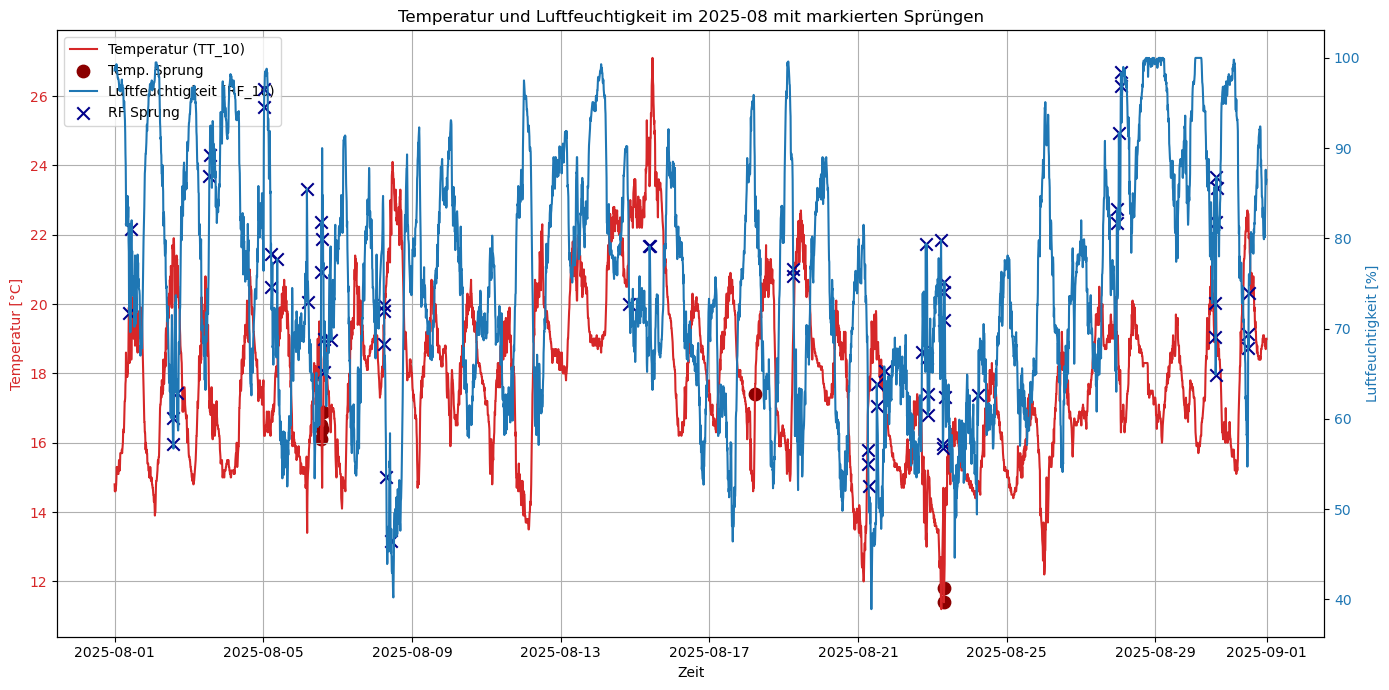

In [95]:

fig, ax1 = plt.subplots(figsize=(14,7))

color_temp = 'tab:red'
ax1.set_xlabel('Zeit')
ax1.set_ylabel('Temperatur [°C]', color=color_temp)
ax1.plot(station_month.index, station_month['TT_10'], color=color_temp, label='Temperatur (TT_10)')
ax1.tick_params(axis='y', labelcolor=color_temp)
ax1.scatter(temp_jumps.index, station_month.loc[temp_jumps.index, 'TT_10'], color='darkred', marker='o', s=80, label='Temp. Sprung')

ax2 = ax1.twinx()
color_humidity = 'tab:blue'
ax2.set_ylabel('Luftfeuchtigkeit [%]', color=color_humidity)
ax2.plot(station_month.index, station_month['RF_10'], color=color_humidity, label='Luftfeuchtigkeit (RF_10)')
ax2.tick_params(axis='y', labelcolor=color_humidity)
ax2.scatter(rf_jumps.index, station_month.loc[rf_jumps.index, 'RF_10'], color='darkblue', marker='x', s=80, label='RF Sprung')

plt.title(f'Temperatur und Luftfeuchtigkeit im {monat} mit markierten Sprüngen')
ax1.grid(True)

# Legenden kombinieren
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
plt.show()

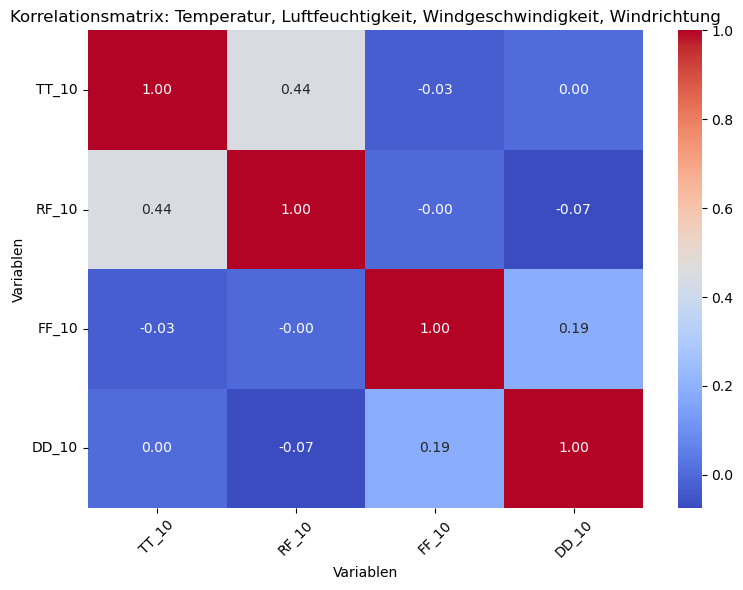

In [96]:
# 1. Winddaten laden
wind_data = pd.read_csv(
    '../data/10minutenwerte_00183_akt/produkt_zehn_min_ff_20240413_20251014_00183.txt',   # Pfad anpassen
    sep=';',
    encoding='utf-8',
    skipfooter=1,
    engine='python'
)

# 'eor' Spalte entfernen
if 'eor' in wind_data.columns:
    wind_data = wind_data.drop(columns=['eor'])

# MESS_DATUM in datetime umwandeln
wind_data['MESS_DATUM'] = pd.to_datetime(wind_data['MESS_DATUM'], format='%Y%m%d%H%M')

# Index setzen und sortieren
wind_data = wind_data.set_index('MESS_DATUM').sort_index()

# 2. Temperatur- und Feuchtigkeitsdaten (dein vorhandener DataFrame)
# station_data_air_10min mit Index MESS_DATUM

# 3. DataFrames zusammenführen (inner join auf Zeitindex)
combined_data = pd.merge(
    station_data_air_10min[['TT_10', 'RF_10']],
    wind_data[['FF_10', 'DD_10']],
    left_index=True,
    right_index=True,
    how='inner'
)

# Korrelation berechnen
correlation_matrix = combined_data.corr()

# Plot der Korrelationsmatrix als Heatmap mit Achsenbeschriftung
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.columns
)
plt.title('Korrelationsmatrix: Temperatur, Luftfeuchtigkeit, Windgeschwindigkeit, Windrichtung')
plt.xlabel('Variablen')
plt.ylabel('Variablen')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [97]:
solar_data = pd.read_csv(
    '../data/10minutenwerte_00183_akt/produkt_zehn_min_sd_20240413_20251014_00183.txt',   # Dateiname anpassen
    sep=';',
    encoding='utf-8',
    skipfooter=1,
    engine='python'
)

# 'eor' entfernen, falls vorhanden
if 'eor' in solar_data.columns:
    solar_data = solar_data.drop(columns=['eor'])

# MESS_DATUM in datetime umwandeln
solar_data['MESS_DATUM'] = pd.to_datetime(solar_data['MESS_DATUM'], format='%Y%m%d%H%M')

# Index setzen
solar_data = solar_data.set_index('MESS_DATUM').sort_index()

In [98]:
combined_data = pd.merge(
    combined_data,
    solar_data[['SD_10']],  # ggf. weitere Spalten hinzufügen
    left_index=True,
    right_index=True,
    how='inner'
)

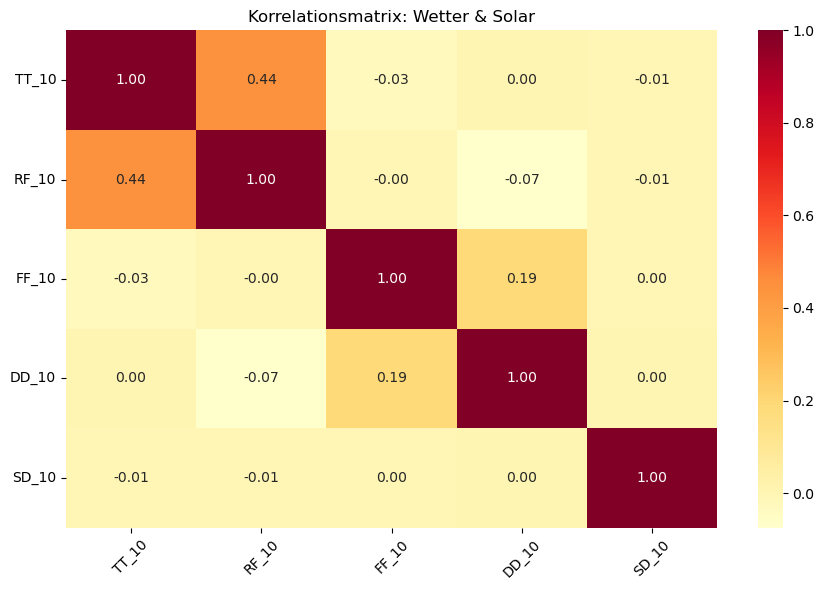

In [99]:
correlation_matrix = combined_data.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='YlOrRd',
    xticklabels=correlation_matrix.columns,
    yticklabels=correlation_matrix.columns
)
plt.title('Korrelationsmatrix: Wetter & Solar')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [100]:
# Kombinieren aller relevanten Spalten in einem gemeinsamen DataFrame
combined_data_full = pd.merge(
    station_data_air_10min[['TT_10', 'TM5_10', 'RF_10']],  # Temperatur, Feuchte
    wind_data[['FF_10', 'DD_10']],                         # Wind
    left_index=True,
    right_index=True,
    how='inner'
)

# Solar-Daten (z. B. Sonnenscheindauer) hinzufügen
combined_data_full = pd.merge(
    combined_data_full,
    solar_data[['SD_10']],                                 # Solar
    left_index=True,
    right_index=True,
    how='inner'
)

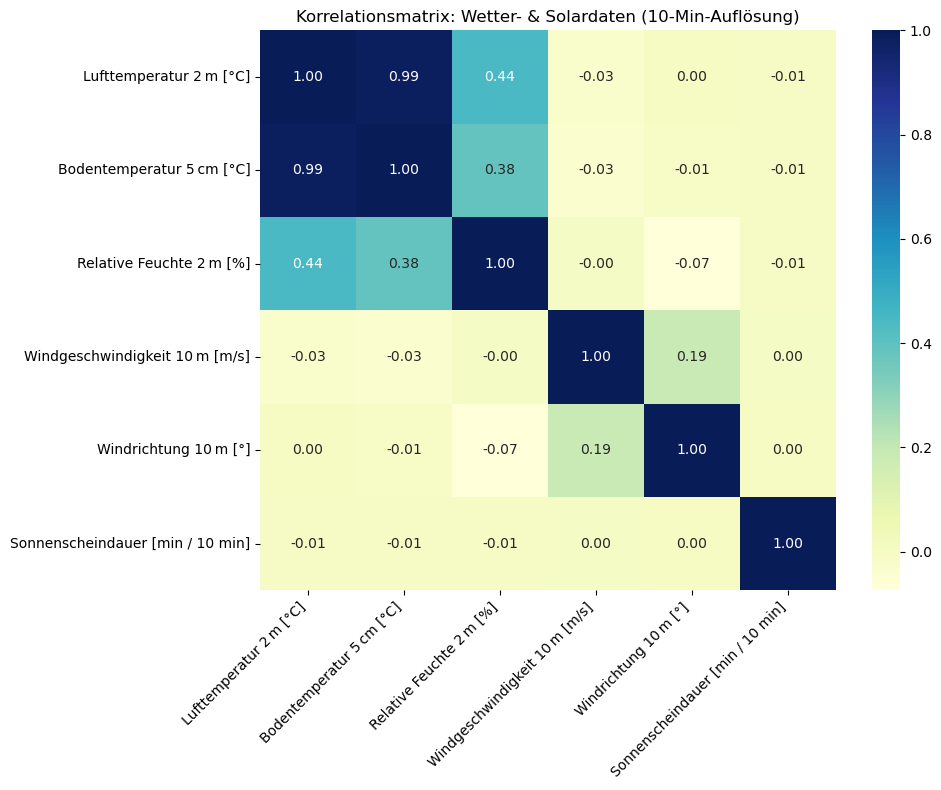

In [101]:
label_mapping = {
    'TT_10': 'Lufttemperatur 2 m [°C]',
    'TM5_10': 'Bodentemperatur 5 cm [°C]',
    'RF_10': 'Relative Feuchte 2 m [%]',
    'FF_10': 'Windgeschwindigkeit 10 m [m/s]',
    'DD_10': 'Windrichtung 10 m [°]',
    'SD_10': 'Sonnenscheindauer [min / 10 min]'
}
# Korrelationsmatrix berechnen
corr = combined_data_full.corr()

# Achsenbeschriftungen ersetzen
corr.index = [label_mapping.get(col, col) for col in corr.index]
corr.columns = [label_mapping.get(col, col) for col in corr.columns]

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    xticklabels=True,
    yticklabels=True
)
plt.title("Korrelationsmatrix: Wetter- & Solardaten (10-Min-Auflösung)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [102]:
def compute_refractivity(T_C, RH, p_hPa):
    T_K = T_C + 273.15
    # Sättigungsdampfdruck nach Magnusformel (Einfachformel)
    e_s = 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))  # in hPa
    e = RH / 100.0 * e_s  # tatsächlicher Dampfdruck

    N = 77.6 * (p_hPa / T_K) + 3.73e5 * (e / (T_K ** 2))
    return N

In [103]:
# Annahme: station_data_air_10min hat Spalten: TT_10 (°C), RF_10 (%), PP_10 (hPa)
station_data_air_10min['N_refractivity'] = compute_refractivity(
    station_data_air_10min['TT_10'],
    station_data_air_10min['RF_10'],
    station_data_air_10min['PP_10']
)

In [104]:
station_data_air_10min['N'] = compute_refractivity(
    station_data_air_10min['TT_10'],
    station_data_air_10min['RF_10'],
    station_data_air_10min['PP_10']
)
# Gradient über 10-Minuten-Zeitschritte, skaliert auf N/h
station_data_air_10min['dN_dt'] = station_data_air_10min['N'].diff() * 6  # 6 × 10min = 1h

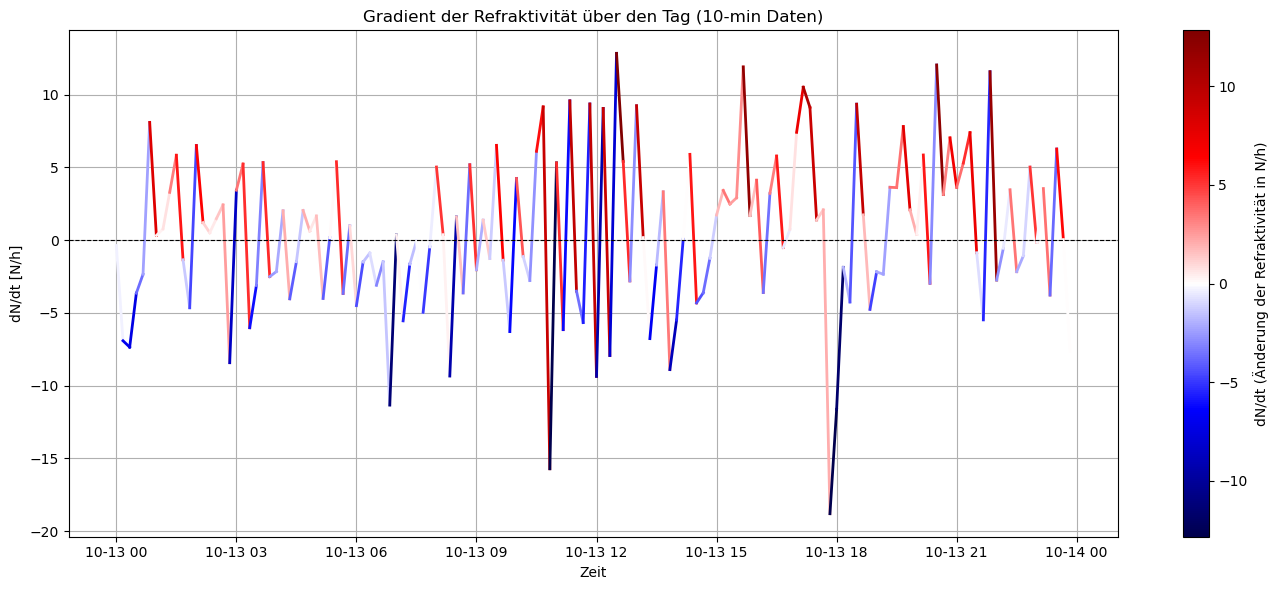

In [105]:
# Beispieltag auswählen
tag = '2025-10-13'
daily_data = station_data_air_10min.loc[tag].copy()

# Werte vorbereiten
times = daily_data.index
gradient = daily_data['dN_dt']

# Farbskala: rot = steigend, blau = fallend
norm = plt.Normalize(vmin=-abs(gradient.max()), vmax=abs(gradient.max()))
colors = plt.cm.seismic(norm(gradient))  # rote & blaue Farbskala

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
for i in range(len(times)-1):
    ax.plot(times[i:i+2], gradient.iloc[i:i+2], color=colors[i], linewidth=2)

ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_title('Gradient der Refraktivität über den Tag (10-min Daten)')
ax.set_ylabel('dN/dt [N/h]')
ax.set_xlabel('Zeit')
ax.grid(True)

# Farbbar hinzufügen
sm = plt.cm.ScalarMappable(cmap='seismic', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('dN/dt (Änderung der Refraktivität in N/h)')

plt.tight_layout()
plt.show()

In [106]:
# 30 Minuten Mittelwerte
bucket_30min = station_data_air_10min.resample('30T').mean()

# 1 Stunde Mittelwerte
bucket_1h = station_data_air_10min.resample('1H').mean()


C:\Users\User\AppData\Local\Temp\ipykernel_15852\3858147556.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  bucket_30min = station_data_air_10min.resample('30T').mean()
C:\Users\User\AppData\Local\Temp\ipykernel_15852\3858147556.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bucket_1h = station_data_air_10min.resample('1H').mean()


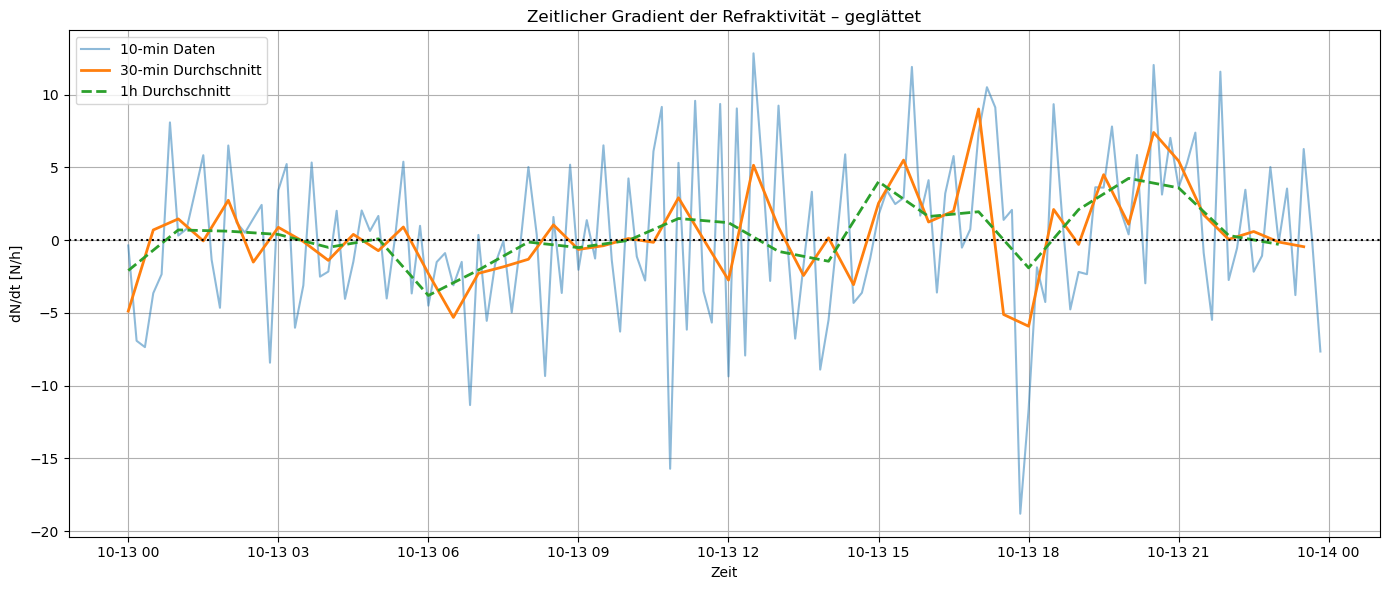

In [107]:
# Zeitraum einschränken (z. B. ein Tag)
tag = '2025-10-13'
n_original = station_data_air_10min['dN_dt'].loc[tag]
n_30min = bucket_30min['dN_dt'].loc[tag]
n_1h = bucket_1h['dN_dt'].loc[tag]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(n_original.index, n_original, label='10-min Daten', alpha=0.5)
plt.plot(n_30min.index, n_30min, label='30-min Durchschnitt', linewidth=2)
plt.plot(n_1h.index, n_1h, label='1h Durchschnitt', linewidth=2, linestyle='--')

plt.axhline(0, color='black', linestyle=':')
plt.title('Zeitlicher Gradient der Refraktivität – geglättet')
plt.ylabel('dN/dt [N/h]')
plt.xlabel('Zeit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [115]:
# Beispiel: Ein kompletter Monat
start_date = '2025-10-01'
end_date = '2025-10-31'

# Zeitraum einschränken
df_period = station_data_air_10min.loc[start_date:end_date].copy()

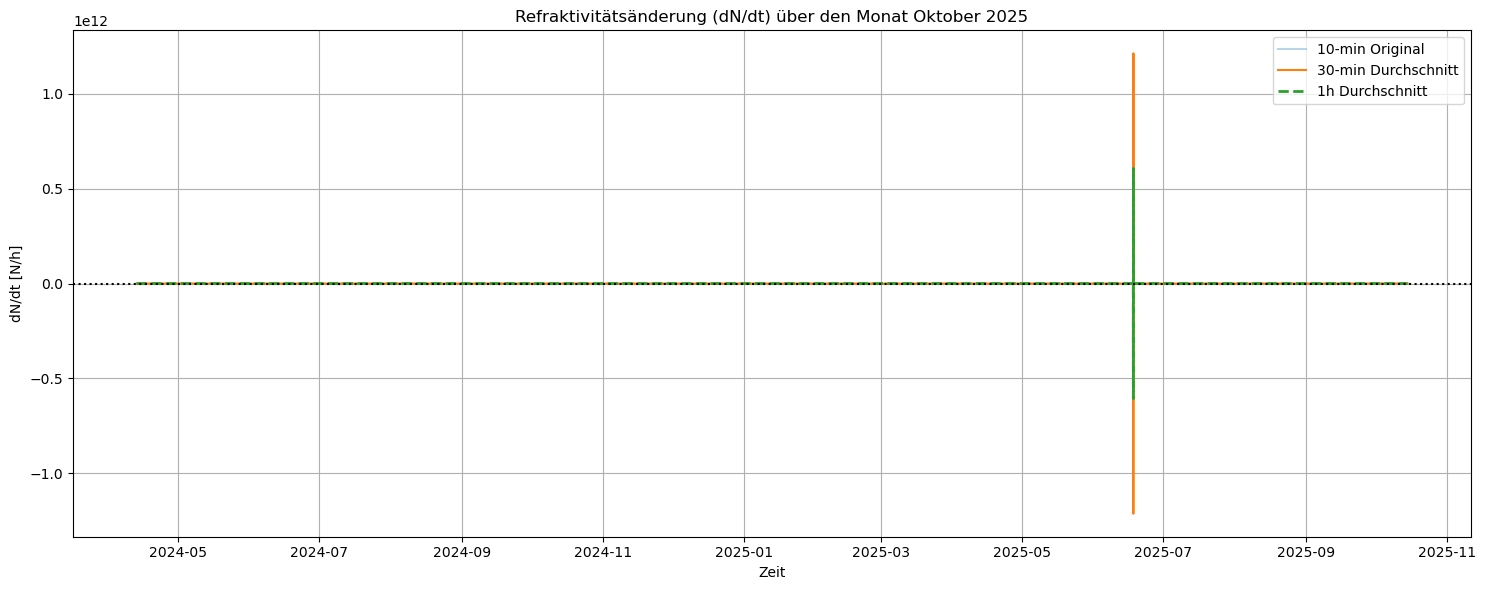

In [116]:
plt.figure(figsize=(15, 6))

plt.plot(df_period.index, df_period['dN_dt'], label='10-min Original', alpha=0.3)
plt.plot(bucket_30min.index, bucket_30min['dN_dt'], label='30-min Durchschnitt', linewidth=1.5)
plt.plot(bucket_1h.index, bucket_1h['dN_dt'], label='1h Durchschnitt', linewidth=2, linestyle='--')

plt.axhline(0, color='black', linestyle=':')
plt.title('Refraktivitätsänderung (dN/dt) über den Monat Oktober 2025')
plt.ylabel('dN/dt [N/h]')
plt.xlabel('Zeit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [117]:
threshold = 10
events = bucket_30min[bucket_30min['dN_dt'].abs() > threshold]
print(events[['dN_dt']])

                         dN_dt
MESS_DATUM                    
2024-04-17 10:00:00  10.863454
2024-04-18 11:30:00 -22.004322
2024-04-18 12:00:00  14.524110
2024-04-18 13:30:00 -11.027862
2024-04-18 14:30:00  11.472939
...                        ...
2025-10-02 08:00:00 -10.606364
2025-10-08 22:30:00 -10.144471
2025-10-09 04:00:00 -15.779607
2025-10-12 19:00:00 -14.670910
2025-10-12 22:00:00 -10.367782

[636 rows x 1 columns]


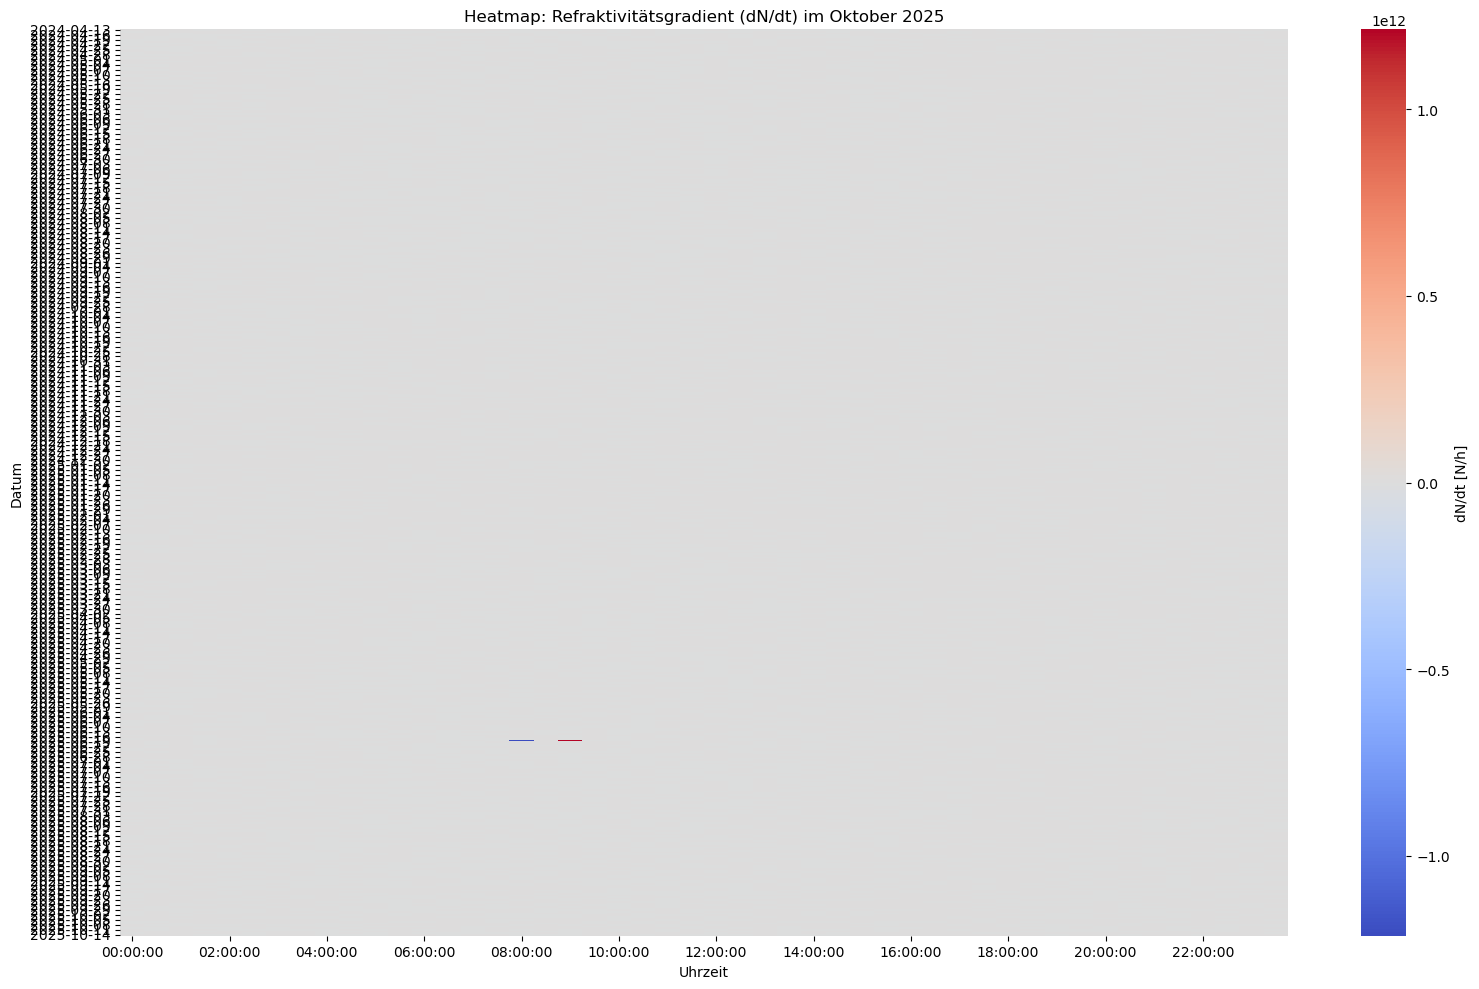

In [118]:
bucket_30min['date'] = bucket_30min.index.date
bucket_30min['time'] = bucket_30min.index.time

heatmap_data = bucket_30min.pivot(index='date', columns='time', values='dN_dt')

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'dN/dt [N/h]'},
    xticklabels=4,
    yticklabels=3
)

plt.title('Heatmap: Refraktivitätsgradient (dN/dt) im Oktober 2025')
plt.xlabel('Uhrzeit')
plt.ylabel('Datum')
plt.tight_layout()
plt.show()

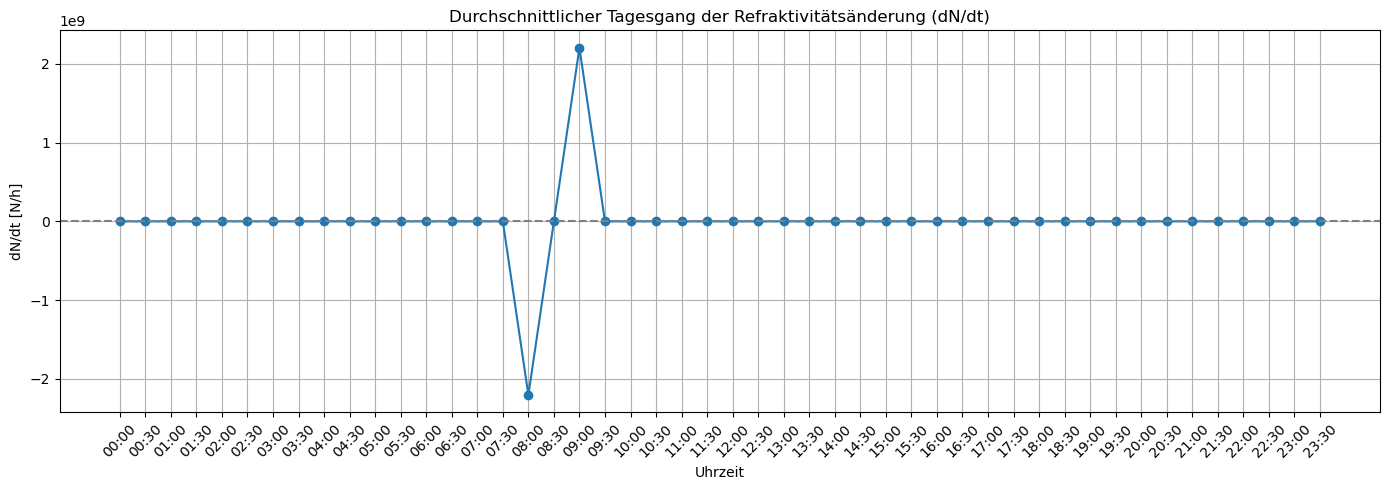

In [120]:
# Uhrzeiten als Strings formatieren (z.B. 'HH:MM')
times_str = [t.strftime('%H:%M') for t in tagesgang.index]

plt.figure(figsize=(14,5))
plt.plot(times_str, tagesgang.values, marker='o')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Durchschnittlicher Tagesgang der Refraktivitätsänderung (dN/dt)')
plt.xlabel('Uhrzeit')
plt.ylabel('dN/dt [N/h]')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [125]:
import plotly.express as px

# Prüfe, ob die Spalten datetime.time-Objekte sind, und wandle sie ggf. um
if not isinstance(heatmap_data.columns[0], str):
    heatmap_data.columns = [t.strftime('%H:%M') for t in heatmap_data.columns]

# Falls Index kein String ist, umwandeln
if not isinstance(heatmap_data.index[0], str):
    heatmap_data.index = heatmap_data.index.astype(str)

fig = px.imshow(
    heatmap_data,
    labels=dict(x="Uhrzeit", y="Datum", color="dN/dt [N/h]"),
    x=heatmap_data.columns,
    y=heatmap_data.index,
    color_continuous_scale='RdBu',
    origin='lower',
    aspect='auto',
    title='Interaktive Heatmap: Refraktivitätsgradient (dN/dt) im Oktober 2025'
)

fig.update_layout(
    xaxis=dict(tickangle=45),
    height=600,
    width=900
)

fig.show()

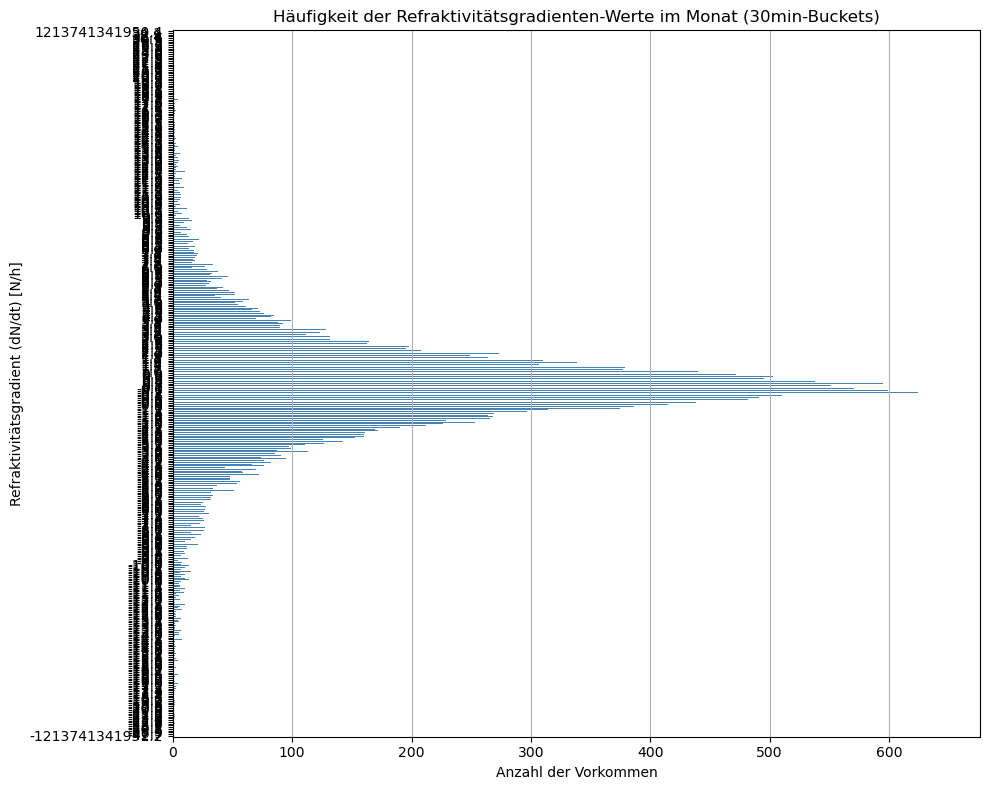

In [128]:
# Werte auf eine Nachkommastelle runden
rounded_values = bucket_30min['dN_dt'].round(1)

# Häufigkeiten zählen
value_counts = rounded_values.value_counts().sort_index()

# Plot horizontal (gedreht)
plt.figure(figsize=(10, 8))
value_counts.plot(kind='barh', color='steelblue')
plt.xlabel('Anzahl der Vorkommen')
plt.ylabel('Refraktivitätsgradient (dN/dt) [N/h]')
plt.title('Häufigkeit der Refraktivitätsgradienten-Werte im Monat (30min-Buckets)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


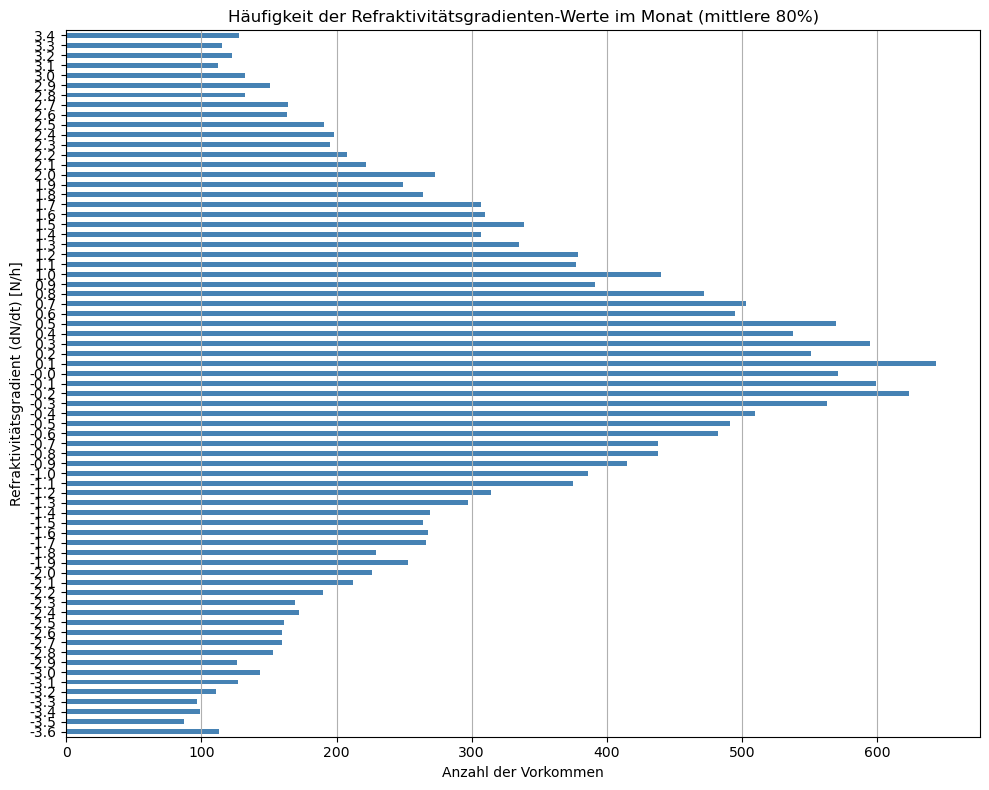

In [133]:
# kumulative Verteilung berechnen (nach sortierten Index)
cum_dist = value_counts.cumsum() / value_counts.sum()

# Grenzen finden: z.B. 10% und 90% Quantil (du kannst auch andere wählen)
lower_bound = cum_dist[cum_dist >= 0.10].index[0]
upper_bound = cum_dist[cum_dist <= 0.90].index[-1]

# Werte filtern, die zwischen diesen Grenzen liegen
filtered_counts = value_counts.loc[lower_bound:upper_bound]

# Plot horizontal
plt.figure(figsize=(10, 8))
filtered_counts.plot(kind='barh', color='steelblue')
plt.xlabel('Anzahl der Vorkommen')
plt.ylabel('Refraktivitätsgradient (dN/dt) [N/h]')
plt.title('Häufigkeit der Refraktivitätsgradienten-Werte im Monat (mittlere 80%)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()